In [1]:
import sys
print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)

Python version
3.6.13 |Anaconda, Inc.| (default, Mar 16 2021, 11:37:27) [MSC v.1916 64 bit (AMD64)]
Version info.
sys.version_info(major=3, minor=6, micro=13, releaselevel='final', serial=0)


In [2]:
import sanitizer as sn
import data_reader as dr

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model, metrics

%matplotlib inline

In [4]:
import pprint

pp = pprint.PrettyPrinter()

In [5]:
# mongodb connection details
mongodb_URI = "mongodb://localhost:27017"
database_name = "riskMetrics22420210423"

In [6]:
# get data from mongodb
mongo_data = dr.read_data(mongodb_URI, database_name)

In [7]:
# temp list to stora data from database cursor
measurements = []

In [8]:
# sanitize data
for d in mongo_data:
    measurements.append(sn.sanitize(d))

In [9]:
# Initializing the dataframe
data = pd.DataFrame(measurements)

In [10]:
# Check the shape of dataframe
data.shape

(1327, 13)

In [11]:
data.head()

,classification,configuration,drugAmount,etCO2,lockoutInterval,mvpNode,respirationRate,riskValue,takingOtherMedications,o2Supplement,apnea,riskAge,weight
0,1,2,1,43,1,7.86125,12,22.7100,0,0,0,0,2
1,1,2,1,43,1,7.68750,15,22.5625,0,0,0,0,2
2,2,2,1,30,1,20.64750,15,35.7825,0,0,0,0,2
3,2,2,1,30,1,20.62375,15,35.8925,0,0,0,0,2
4,2,2,1,30,1,20.54875,15,35.4500,0,0,0,0,2


## Data description

#### Risk classifications:
* 1 - Negligible
* 2 - Minor
* 3 - Serious
* 4 - Critical
* 5 - Catastrophical


#### Available Configurations:
* 1 - Pulse Oximeter
* 2 - Capnometer
* 3 - Pulse Oximeter + Capnometer

#### Drug Amount Classification:
* 1 - Low
* 2 - Moderate
* 3 - High

#### Lockout Interval:
* 1 - Low
* 2 - Medium
* 3 - High

#### Level of O2 supplement:
* 0 - None
* 1 - Minimal
* 2 - Medium
* 3 - High

#### Weight classifications:
* 1 - Underweight
* 2 - Normal Weight
* 3 - Overweight
* 4 - Obesity I
* 5 - Obesity II
* 6 - Obesity III

#### Is Taking Other Medications, has Apnea and has a risk age:
* 0 - No (false)
* 1 - Yes (true)

In [12]:
# Viewing the data statistics
data.describe()

,classification,configuration,drugAmount,etCO2,lockoutInterval,mvpNode,respirationRate,riskValue,takingOtherMedications,o2Supplement,apnea,riskAge,weight
count,1327.000000,1327.0,1327.0,1327.000000,1327.0,1327.000000,1327.000000,1327.000000,1327.0,1327.0,1327.0,1327.0,1327.0
mean,1.998493,2.0,1.0,30.019593,1.0,20.605196,14.997739,35.784215,0.0,0.0,0.0,0.0,2.0
std,0.038808,0.0,0.0,0.504498,0.0,0.508681,0.082354,0.558512,0.0,0.0,0.0,0.0,0.0
min,1.000000,2.0,1.0,30.000000,1.0,7.687500,12.000000,22.562500,0.0,0.0,0.0,0.0,2.0
25%,2.000000,2.0,1.0,30.000000,1.0,20.558750,15.000000,35.647500,0.0,0.0,0.0,0.0,2.0
50%,2.000000,2.0,1.0,30.000000,1.0,20.622500,15.000000,35.812500,0.0,0.0,0.0,0.0,2.0
75%,2.000000,2.0,1.0,30.000000,1.0,20.694375,15.000000,35.952500,0.0,0.0,0.0,0.0,2.0
max,2.000000,2.0,1.0,43.000000,1.0,21.105000,15.000000,36.500000,0.0,0.0,0.0,0.0,2.0


In [13]:
# Finding out the correlation between the features
corr = data.corr()
corr.shape

(13, 13)

<AxesSubplot:>

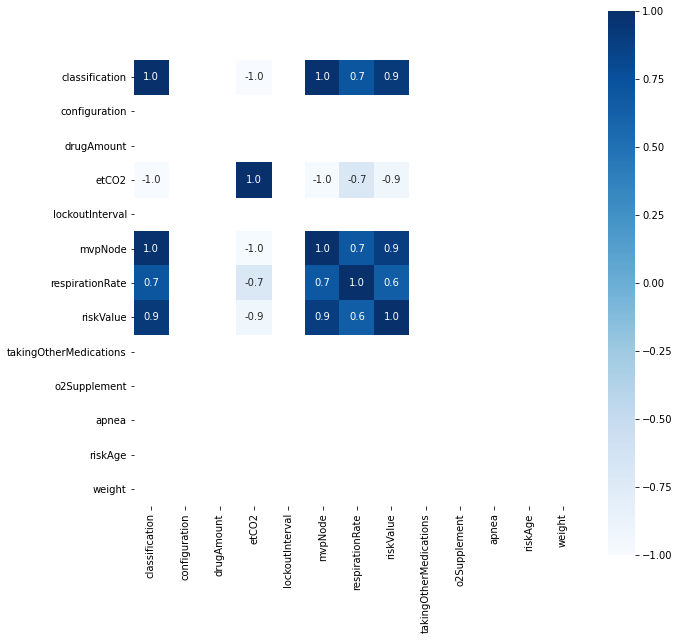

In [14]:
# Plotting the heatmap of correlation between features
plt.figure(figsize=(10, 10))
sns.heatmap(
    corr,
    cbar=True,
    square=True,
    fmt=".1f",
    annot=True,
    annot_kws={"size": 10},
    cmap="Blues",
)

In [15]:
# Spliting target variable and independent variables
X = data.drop(["riskValue"], axis=1)
y = data["riskValue"]

In [16]:
# Splitting to training and testing data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

# Linear regression

#### Training the model

In [17]:
# Import library for Linear Regression
from sklearn.linear_model import LinearRegression

# Create a Linear regressor
lm = LinearRegression()

# Train the model using the training sets
lm.fit(X_train, y_train)

LinearRegression()

In [18]:
# Value of y intercept
lm.intercept_

218885438356668.03

In [19]:
# Converting the coefficient values to a dataframe
coeffcients = pd.DataFrame([X_train.columns, lm.coef_]).T
coeffcients = coeffcients.rename(columns={0: "Attribute", 1: "Coefficients"})
coeffcients

,Attribute,Coefficients
0,classification,-5.08316e+13
1,configuration,3.99508e+10
2,drugAmount,1.37181e+09
3,etCO2,-3.91012e+12
4,lockoutInterval,0
5,mvpNode,0.0148271
6,respirationRate,-0.0482793
7,takingOtherMedications,0
8,o2Supplement,0
9,apnea,0


In [20]:
# Model prediction on train data
y_pred = lm.predict(X_train)

In [21]:
# Model Evaluation
print("R^2:", metrics.r2_score(y_train, y_pred))
print(
    "Adjusted R^2:",
    1
    - (1 - metrics.r2_score(y_train, y_pred))
    * (len(y_train) - 1)
    / (len(y_train) - X_train.shape[1] - 1),
)
print("MAE:", metrics.mean_absolute_error(y_train, y_pred))
print("MSE:", metrics.mean_squared_error(y_train, y_pred))
print("RMSE:", np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

R^2: 0.8825090434490934
Adjusted R^2: 0.8809681784451471
MAE: 0.17985991379310357
MSE: 0.049619739224138
RMSE: 0.2227548859714148


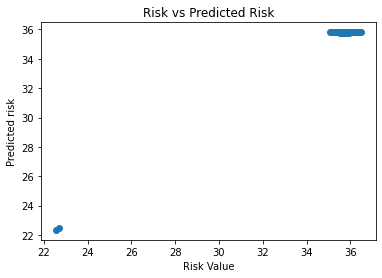

In [22]:
plt.scatter(y_train, y_pred)
plt.xlabel("Risk Value")
plt.ylabel("Predicted risk")
plt.title("Risk vs Predicted Risk")
plt.show()

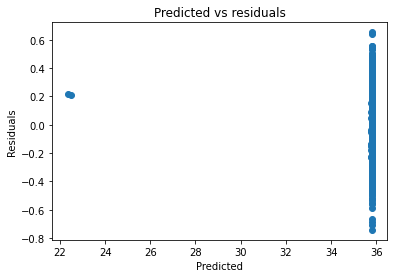

In [23]:
# Checking residuals
plt.scatter(y_pred, y_train - y_pred)
plt.title("Predicted vs residuals")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

In [24]:
predictions = lm.predict(X_test)
y_list = y_test.to_list()

for i in range(20):
    print(
        "Prediction: {:.2f}".format(predictions[i]), "Value: {:.2f}".format(y_list[i])
    )

Prediction: 35.81 Value: 35.85
Prediction: 35.81 Value: 36.16
Prediction: 35.81 Value: 35.62
Prediction: 35.81 Value: 35.92
Prediction: 35.81 Value: 35.70
Prediction: 35.81 Value: 35.80
Prediction: 35.81 Value: 35.86
Prediction: 35.81 Value: 35.86
Prediction: 35.81 Value: 35.50
Prediction: 35.81 Value: 35.84
Prediction: 35.81 Value: 35.74
Prediction: 35.81 Value: 35.60
Prediction: 35.81 Value: 35.47
Prediction: 35.81 Value: 35.90
Prediction: 35.81 Value: 35.39
Prediction: 35.81 Value: 35.74
Prediction: 35.81 Value: 36.15
Prediction: 35.81 Value: 35.75
Prediction: 35.81 Value: 35.59
Prediction: 35.81 Value: 35.08


# SVM Regressor


In [25]:
# Creating scaled set to be used in model to improve our results
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#### Train the model

In [26]:
# Import SVM Regressor
from sklearn import svm

# Create a SVM Regressor
reg = svm.SVR()

In [27]:
# Train the model using the training sets
reg.fit(X_train, y_train)

SVR()

#### Model Evaluation

In [28]:
# Model prediction on train data
y_pred = reg.predict(X_train)

In [29]:
# Model Evaluation
print("R^2:", metrics.r2_score(y_train, y_pred))
print(
    "Adjusted R^2:",
    1
    - (1 - metrics.r2_score(y_train, y_pred))
    * (len(y_train) - 1)
    / (len(y_train) - X_train.shape[1] - 1),
)
print("MAE:", metrics.mean_absolute_error(y_train, y_pred))
print("MSE:", metrics.mean_squared_error(y_train, y_pred))
print("RMSE:", np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

R^2: 0.3342369197959222
Adjusted R^2: 0.32550560071127854
MAE: 0.201934729499232
MSE: 0.28117049511356906
RMSE: 0.5302551226660324


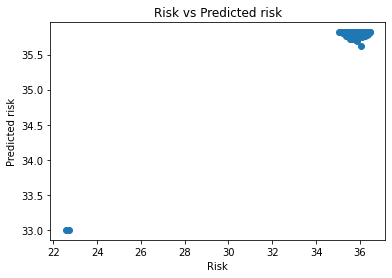

In [30]:
plt.scatter(y_train, y_pred)
plt.xlabel("Risk")
plt.ylabel("Predicted risk")
plt.title("Risk vs Predicted risk")
plt.show()

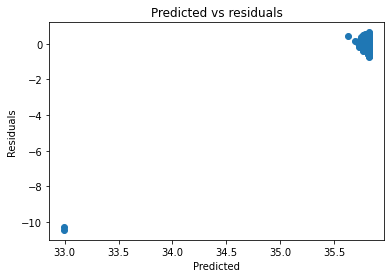

In [31]:
# Checking residuals
plt.scatter(y_pred, y_train - y_pred)
plt.title("Predicted vs residuals")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

#### For test data

In [32]:
# Predicting Test data with the model
y_test_pred = reg.predict(X_test)

In [33]:
# Model Evaluation
acc_svm = metrics.r2_score(y_test, y_test_pred)
print("R^2:", acc_svm)
print(
    "Adjusted R^2:",
    1
    - (1 - metrics.r2_score(y_test, y_test_pred))
    * (len(y_test) - 1)
    / (len(y_test) - X_test.shape[1] - 1),
)
print("MAE:", metrics.mean_absolute_error(y_test, y_test_pred))
print("MSE:", metrics.mean_squared_error(y_test, y_test_pred))
print("RMSE:", np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

R^2: -0.012273949229337111
Adjusted R^2: -0.04374360568206259
MAE: 0.18488287480296872
MSE: 0.05433593848809275
RMSE: 0.23310070460659862


In [34]:
predictions = lm.predict(X_test)
y_list = y_test.to_list()

for i in range(20):
    print(
        "Prediction: {:.2f}".format(predictions[i]), "Value: {:.2f}".format(y_list[i])
    )

Prediction: 216704814192894.25 Value: 35.85
Prediction: 216704814192894.25 Value: 36.16
Prediction: 216704814192894.25 Value: 35.62
Prediction: 216704814192894.25 Value: 35.92
Prediction: 216704814192894.25 Value: 35.70
Prediction: 216704814192894.25 Value: 35.80
Prediction: 216704814192894.25 Value: 35.86
Prediction: 216704814192894.25 Value: 35.86
Prediction: 216704814192894.25 Value: 35.50
Prediction: 216704814192894.25 Value: 35.84
Prediction: 216704814192894.25 Value: 35.74
Prediction: 216704814192894.25 Value: 35.60
Prediction: 216704814192894.25 Value: 35.47
Prediction: 216704814192894.25 Value: 35.90
Prediction: 216704814192894.25 Value: 35.39
Prediction: 216704814192894.25 Value: 35.74
Prediction: 216704814192894.25 Value: 36.15
Prediction: 216704814192894.25 Value: 35.75
Prediction: 216704814192894.25 Value: 35.59
Prediction: 216704814192894.25 Value: 35.08
